In [1]:
import collections
import networkx as nx
import pulp
import matplotlib.pyplot as plt

In [2]:
def get_graph_from_file(input_file: str) -> nx.classes.graph.Graph:
    graph = nx.Graph()
    graph.add_edge(1, 2)
    with open(input_file, "r") as file:
        for line in file:
            words = line.rstrip("\n").split()
            if len(words) == 0:
                continue
            elif words[0] == "c":
                continue
            elif words[0] == "p":
                print(f"Graph with {words[2]} nodes and {words[3]} edges")
            elif words[0] == "e":
                from_node = int(words[1]) - 1
                to_node = int(words[2]) - 1
                graph.add_edge(from_node, to_node)

    return graph

In [3]:
class Model:
    def __init__(self, graph: nx.classes.graph.Graph):
        self.problem = pulp.LpProblem("GraphColoringProblem")
        self.nodes = sorted(list(graph.nodes))
        self.colors = self.nodes.copy()

        # 変数定義
        self.colorvars = {
            color: pulp.LpVariable(f"Color {color} is used", cat=pulp.LpBinary) for color in self.colors
        }
        self.nodecolor = {
            (node, color): pulp.LpVariable(f"Node{node} is colored by color {color}", cat=pulp.LpBinary) for node in self.nodes for color in self.colors
        }

        # 1 つのノードは 1 つの色で塗られる
        for node in self.nodes:
            self.problem += pulp.lpSum([nc for (n, c), nc in self.nodecolor.items() if n == node]) == 1

        # 隣り合うノードは同じ色で塗れない + 色採用
        for from_node, to_node in graph.edges:
            for color, colorvar in self.colorvars.items():
                self.problem += self.nodecolor[(from_node, color)] + self.nodecolor[(to_node, color)] <= colorvar

        # 推奨らしい
        for color, colorvar in self.colorvars.items():
            self.problem += colorvar <= pulp.lpSum([self.nodecolor[(node, color)] for node in self.nodes])
        for i in self.colorvars:
            if i + 1 == len(self.colorvars):
                continue
            self.problem += self.colorvars[i] <= self.colorvars[i + 1]

        # 使われた色の数を最小化
        self.problem.setObjective(pulp.lpSum(self.colorvars.values()))

    def solve(self, msg=True):
        self.problem.solve(pulp.PULP_CBC_CMD(timeLimit=300, threads=4, msg=msg))

In [4]:
input_file = "data/test.txt"
# input_file = "data/queen7_7.col"
graph = get_graph_from_file(input_file)
for from_node, to_node in graph.edges:
    print(f"{from_node} -> {to_node}")

Graph with 10 nodes and 15 edges
1 -> 2
1 -> 0
1 -> 6
2 -> 3
2 -> 7
0 -> 4
0 -> 5
3 -> 4
3 -> 8
4 -> 9
5 -> 7
5 -> 8
6 -> 9
6 -> 8
7 -> 9


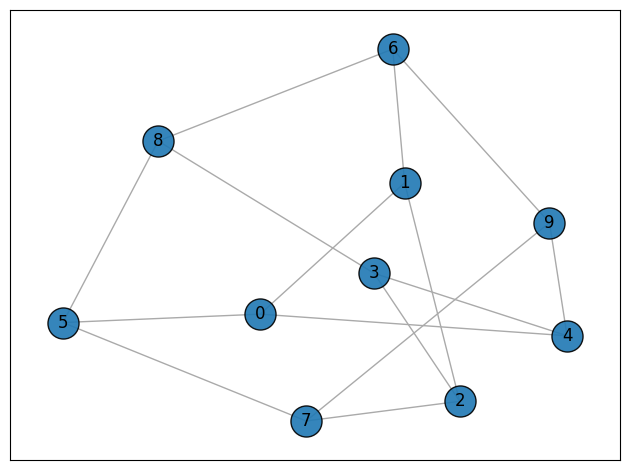

In [5]:
pos = nx.spring_layout(graph, seed=0)
nx.draw_networkx_nodes(
    graph,
    pos,
    node_size=500,
    # node_color=draw_nodecolor,
    # cmap=cmap,
    alpha=0.9,
    edgecolors="#000000",
)
nx.draw_networkx_edges(graph, pos, edge_color="#aaaaaa")
nx.draw_networkx_labels(graph, pos)
plt.tight_layout()
plt.show()

In [6]:
model = Model(graph)
model.solve(msg=False)

In [7]:
print(f"Status: {pulp.LpStatus[model.problem.status]}")
print(f"Best objective value: {model.problem.objective.value()}")
print(f"Solution time: {model.problem.solutionTime}")

Status: Optimal
Best objective value: 3.0
Solution time: 0.1118021011352539


In [8]:
used_colors = collections.Counter(
    [
        color
        for color, colorvar in model.colorvars.items()
        if pulp.value(colorvar) >= 0.99
    ]
)
for idx, used_color in enumerate(used_colors):
    used_colors[used_color] = idx

node_color = {}
for (node, color), nodecolor in model.nodecolor.items():
    if pulp.value(nodecolor) >= 0.99:
        node_color[node] = used_colors[color]

for node in model.nodes:
    print(f"node {node}: color {node_color[node]}")

node 0: color 2
node 1: color 1
node 2: color 0
node 3: color 1
node 4: color 0
node 5: color 0
node 6: color 0
node 7: color 2
node 8: color 2
node 9: color 1


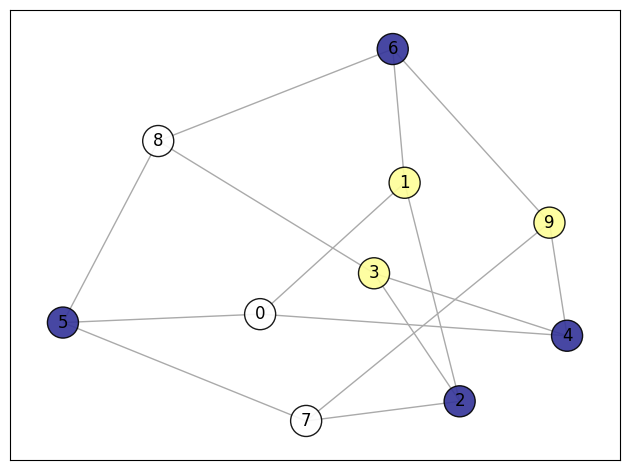

In [9]:
cmap = plt.get_cmap("terrain")
draw_colors = [i / (len(used_colors) - 1) for i in used_colors.values()]
draw_nodecolor = [draw_colors[node_color[node]] for node in graph.nodes]

pos = nx.spring_layout(graph, seed=0)
nx.draw_networkx_nodes(
    graph,
    pos,
    node_size=500,
    node_color=draw_nodecolor,
    cmap=cmap,
    alpha=0.9,
    edgecolors="#000000",
)
nx.draw_networkx_edges(graph, pos, edge_color="#aaaaaa")
nx.draw_networkx_labels(graph, pos)
plt.tight_layout()
plt.show()